In [12]:
!pip install kneed

In [1]:
# --- 1. CORE LIBRARIES AND UTILITIES ---
# Standard data manipulation and visualization libraries
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

# --- 2. SCIKIT-LEARN: MODEL SELECTION & METRICS ---
# Tools for splitting data, cross-validation, and performance evaluation
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    cross_val_score, 
    GridSearchCV
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    roc_auc_score
)
from sklearn.pipeline import Pipeline # For creating robust modeling workflows
from sklearn.impute import SimpleImputer # Tool to handle NaNs
from sklearn.preprocessing import FunctionTransformer, StandardScaler

import lightgbm as lgb

import os
import sys
import joblib
import json

# Define project Path in Colab
PROJECT_BASE_PATH = '/content/drive/MyDrive/Project_01' 

# ADD 'src' DIRECTORY TO PYTHON PATH
SRC_PATH = os.path.join(PROJECT_BASE_PATH, 'src')

# verify if SRC_PATH is already in sys.path
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
    print("✅ Successfully added 'src' directory to Python path.")

# IMPORT Paths CLASS FROM config MODULE
from config import Paths

try:
    from config import Paths
    
    # 3. Initialize instance of Paths class to manage project directories and files
    cfg = Paths(PROJECT_BASE_PATH) # <-- Change here if needed
    cfg.create_dirs() 
    
    print("\n✅ Project configuration (Paths) initialized successfully.")
    print(f"Raw Data Path check: {cfg.TRAIN_RAW_FILE}")
    
except ImportError:
    print("❌ Error: Could not import Paths from config module.")

FINAL_TRAIN_FILE = os.path.join(cfg.DATA_PROCESSED_DIR, 'train_final_encoded.parquet')
FINAL_TEST_FILE = os.path.join(cfg.DATA_PROCESSED_DIR, 'test_final_encoded.parquet')

try:
    # Read the Parquet files
    df_train= pd.read_parquet(FINAL_TRAIN_FILE)
    df_test = pd.read_parquet(FINAL_TEST_FILE)
    
    print(f"✅ Loaded Encoded Train Data. Shape: {df_train.shape}")
    print(f"✅ Loaded Encoded Test Data. Shape: {df_test.shape}")

except FileNotFoundError:
    print("❌ ERROR: Parquet files not found. Ensure that the parquet was executed successfully in Feature_Eng notebook and saved the files.")
    # Exit or raise an error if critical data is missing
    raise

✅ Successfully added 'src' directory to Python path.

✅ Project configuration (Paths) initialized successfully.
Raw Data Path check: /content/drive/MyDrive/Project_01/data/raw/application_train.csv
✅ Loaded Encoded Train Data. Shape: (307511, 135)
✅ Loaded Encoded Test Data. Shape: (48744, 134)


In [4]:
# Final LightGBM Training with Optimized Hyperparameters and Feature Selection via Elbow Method

# --- Exclusions ---
TARGET = "TARGET"

X_train = df_train.drop(columns=[TARGET])
y_train = df_train[TARGET]

# Test set has no TARGET in Home Credit (as expected)
X_test = df_test.copy()
y_test = None   # placeholder, not used

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

# Load best params
params_path = os.path.join(cfg.MODEL_DIR, "best_params.json")
with open(params_path, "r") as f:
    best_params = json.load(f)

print("Best params:", best_params)

Train shape: (307511, 134)
Test shape: (48744, 134)
Best params: {'num_leaves': 70, 'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.02}


In [8]:
print("=== Training Final LightGBM Model with Best Params ===")

final_model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1,
    **best_params
)

final_model.fit(X_train, y_train)

print("Final model trained successfully.")


=== Training Final LightGBM Model with Best Params ===
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.540594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12905
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [9]:
# Feature Importance Calculation

importances = final_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

importance_df = importance_df.sort_values(by="importance", ascending=False)
importance_df.head(20)


,feature,importance
117,PAYMENT_RATE,3351
28,EXT_SOURCE_1,2352
30,EXT_SOURCE_3,2312
29,EXT_SOURCE_2,2089
7,DAYS_BIRTH,1964
10,DAYS_ID_PUBLISH,1670
9,DAYS_REGISTRATION,1407
8,DAYS_EMPLOYED,1406
78,DAYS_LAST_PHONE_CHANGE,1322
129,ORGANIZATION_TYPE_TARGET_ENC,1227


<Figure size 1200x800 with 0 Axes>

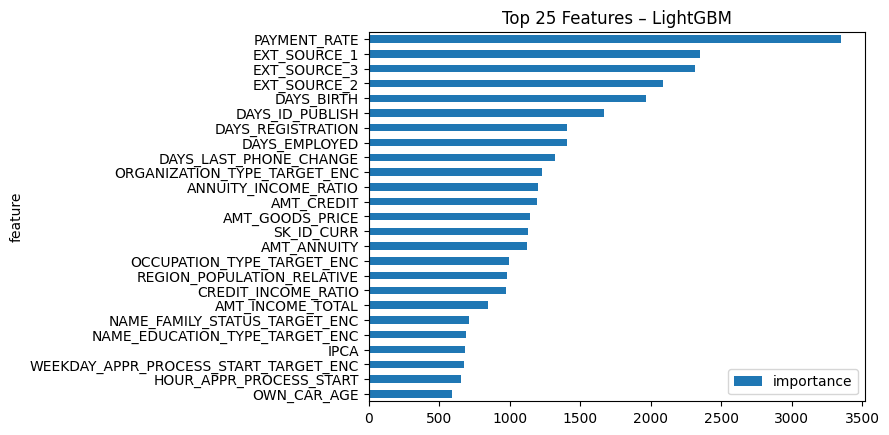

In [10]:
# Visualization of Feature Importance

plt.figure(figsize=(12, 8))
importance_df.head(25).plot(kind='barh', x='feature', y='importance')
plt.gca().invert_yaxis()
plt.title("Top 25 Features – LightGBM")
plt.show()


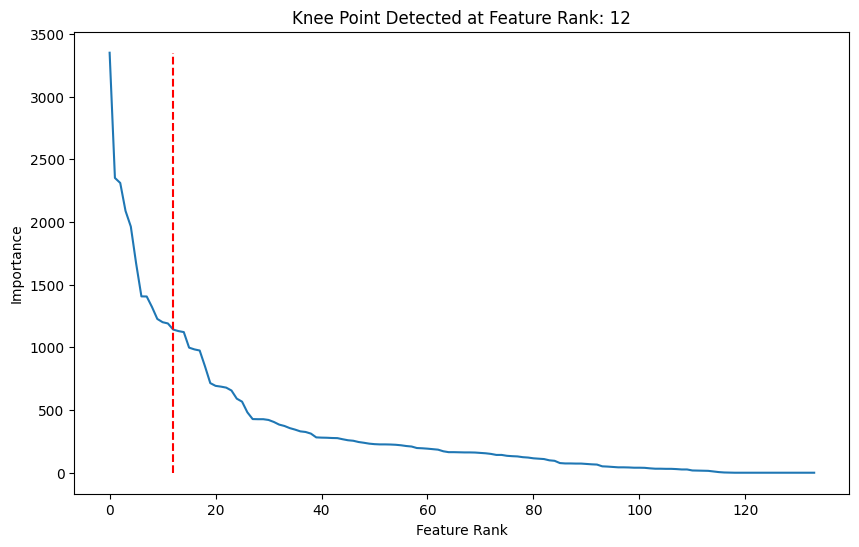

In [13]:
# Kneed method for Feature Selection

from kneed import KneeLocator

x = np.arange(len(importance_df))
y = importance_df['importance'].values

knee = KneeLocator(
    x,
    y,
    curve='convex',
    direction='decreasing'
)

knee_point = knee.knee

if knee_point is None:
    knee_point = 25
    print("Knee not detected. Using 25 features by convention.")

# Visualization of features importance
plt.figure(figsize=(10,6))
plt.plot(x, y, label="Importances")
plt.vlines(knee_point, ymin=min(y), ymax=max(y), linestyles='--', colors='red')
plt.title(f"Knee Point Detected at Feature Rank: {knee_point}")
plt.xlabel("Feature Rank")
plt.ylabel("Importance")
plt.show()

In [14]:
# Selection of the most importante features

N_TOP = knee_point  # ou fixe manualmente: N_FEATURES = 25

final_features = importance_df.head(N_TOP)["feature"].tolist()

print(f"Using TOP {N_TOP} features:")
final_features

Using TOP 12 features:


['PAYMENT_RATE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'DAYS_LAST_PHONE_CHANGE',
 'ORGANIZATION_TYPE_TARGET_ENC',
 'ANNUITY_INCOME_RATIO',
 'AMT_CREDIT']

In [16]:
# Training the model

X_train_final = X_train[final_features]

final_reduced_model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1,
    **best_params
)

final_reduced_model.fit(X_train_final, y_train)

print("Final reduced model trained with", len(final_features), "features.")


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2951
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Final reduced model trained with 12 features.


In [17]:
# MLOPs artifacts
model_path = os.path.join(cfg.MODEL_DIR, "final_lgbm_model.pkl")
joblib.dump(final_reduced_model, model_path)
print(f"Saved final model to {model_path}")

features_path = os.path.join(cfg.MODEL_DIR, "FINAL_MODEL_FEATURES.json")
with open(features_path, "w") as f:
    json.dump(final_features, f, indent=4)
print(f"Saved final feature list to {features_path}")

# Save imputation means
imputation_map = X_train_final.mean().to_dict()
imp_path = os.path.join(cfg.MODEL_DIR, "final_imputation_map.json")
with open(imp_path, "w") as f:
    json.dump(imputation_map, f, indent=4)
print(f"Saved imputation map to {imp_path}")

Saved final model to /content/drive/MyDrive/Project_01/models/final_lgbm_model.pkl
Saved final feature list to /content/drive/MyDrive/Project_01/models/FINAL_MODEL_FEATURES.json
Saved imputation map to /content/drive/MyDrive/Project_01/models/final_imputation_map.json


In [20]:
X_train_final

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,ORGANIZATION_TYPE_TARGET_ENC,ANNUITY_INCOME_RATIO,AMT_CREDIT
0,0.060749,0.083037,0.139376,0.262949,-9461,-2120,-3648.0,-637,-1134.0,0.093406,0.121978,406597.5
1,0.027598,0.311267,0.535276,0.622246,-16765,-291,-1186.0,-1188,-828.0,0.059167,0.132217,1293502.5
2,0.050000,0.505998,0.729567,0.555912,-19046,-2531,-4260.0,-225,-815.0,0.066731,0.100000,135000.0
3,0.094941,0.505998,0.535276,0.650442,-19005,-2437,-9833.0,-3039,-617.0,0.093460,0.219900,312682.5
4,0.042623,0.505998,0.535276,0.322738,-19932,-3458,-4311.0,-3038,-1106.0,0.045455,0.179963,513000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.108198,0.145570,0.535276,0.681632,-9327,-1982,-8456.0,-236,-273.0,0.067930,0.174971,254700.0
307507,0.044524,0.505998,0.535276,0.115992,-20775,-4090,-4388.0,365243,0.0,0.053334,0.166687,269550.0
307508,0.044239,0.744026,0.218859,0.535722,-14966,-5150,-6737.0,-7921,-1909.0,0.058167,0.195941,677664.0
307509,0.054592,0.505998,0.661024,0.514163,-11961,-931,-2562.0,-4786,-322.0,0.079167,0.118158,370107.0
